### Functions related to short-drift acceleration (SDA)

In [1]:
import numpy as np
%run LoadNotebook
%matplotlib inline
import warnings
import DataProcess as R
import INITMAXWELL as INITMAX
import scipy.special as sp
from scipy.special import kn
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.integrate as integrate
warnings.filterwarnings('ignore')

importing Jupyter notebook from DataProcess.ipynb
importing Jupyter notebook from INITMAXWELL.ipynb


In [2]:
'''
energy spectrum of kappa distribution before and after SDA
# me      : electron mass in unit KeV
# num     : data points
# kappa   : used for kappa distribution
# Te      : kappa distribution temperature T/(me*c^2)
# theta_b : angle between B and shock normal or btheta
# beta_sh : shock velocity in upstream rest frame Vsh/c
# r       : compression ratio
# ePhi    : electric potential in  unit 1/(meC^2)
'''
def nonrel_sda_spectrum(me,num,kappa,Te,theta_b,beta_sh,r,ePhi):
    beta    = np.linspace(0.0001,0.5,num)
    fe      = np.linspace(0,1,num)
    gamma   = 1./np.sqrt(1.-beta**2)
    Energy  = (gamma-1)*me # kinetic energy

    '''
    kappa distribution
    '''
    f_kappa0 = (1.+2*(gamma-1)/(2*kappa-3)/Te)**(-kappa-1.)
    dBetadE  = (1.-beta**2)**1.5/beta
    f_kappaE = f_kappa0*dBetadE

    beta_s  = beta_sh/np.cos(theta_b) # dHT and upstream rest frame Transformation v.

    alpha0  = np.arcsin(1/np.sqrt(r))
    D       = np.tan(alpha0)/np.sqrt(1-beta_s**2) # D =gamma_s*tan(alpha0)
    P       = 2.*ePhi    
    beta_thres = np.sqrt((D**2*((1-beta_s)**2*D**2*P**2*(P-(1+beta_s**2))+\
            beta_s**2-P))/(1+D**2*(1-P*beta_s**2)))
    beta_trans = np.sqrt(beta_s**2 -(1.-beta_s**2)*P*np.tan(alpha0)**2)
    E_trans = 1./np.sqrt(1-beta_trans**2)-1.

    '''
    solve t1, and t3. where t3<t2<t1
    '''
    def rootfun(x,i):
        return x**2*(1+D**2*(1-P*beta_s**2))- \
            2*x*D**2*beta_s/beta[i]*(1-P)+\
            D**2/beta[i]**2*(beta_s**2-P)-1
     
    '''
    integrate over SDA region
    '''
    def intsda(x,i):
        jac = (1-beta_s)**4/(1-2*beta_s*beta[i]*x+beta_s**2)**4
        sin = np.sqrt(1-x**2)
        betai_parallel = (2*beta_s- beta[i]*x*(1+beta_s**2))/(1-2*beta_s*beta[i]*x+beta_s**2)
        betai_perp     = beta[i]*sin/(1./np.sqrt(1-beta_s**2)*(1-2*beta_s*beta[i]*x+beta_s**2))
        betai  = np.sqrt(betai_parallel**2+betai_perp**2)
        gammai = 1./np.sqrt(1-betai**2)    
        return jac*(1.+2*(gammai-1)/(2*kappa-3)/Te)**(-kappa-1.)


    for i in range(num):
        f_kappa= (1.+2*(gamma[i]-1)/(2*kappa-3)/Te)**(-kappa-1.)
        if beta[i]<beta_thres:
            fe[i]= 2.*f_kappa
        else:
            t3 = fsolve(rootfun,-1.,args=(i))  
            t1 = fsolve(rootfun,1.,args=(i))  
            if np.abs(t1)>1. or np.abs(t3)>1. or t1<t3:
                pass
                #print ('Error in t1/t3!')            
            if beta[i]<beta_trans:
                result = integrate.quad(intsda, t3, t1, args=(i))
                fe[i] = (2.-(t1-t3))*f_kappa + result[0]
            else:
                result = integrate.quad(intsda, t3, beta_s/beta[i], args=(i))
                fe[i] = (2-(t1-beta_s/beta[i]))*f_kappa+ result[0]
        fe[i] *= 0.5
    # Energy:unit KeV, y: unit f_e(E)
    return Energy, fe*dBetadE, f_kappaE

In [3]:
# ePhi = Delta(Phi)/m_e*c^2
# r = B/B0 compression ratio
# vsh_up = shock velocity in upstream rest frame
def SDA_reflection_curve(vsh_up, theta_b, ePhi, r, bpara_num):
    beta_parallel = np.linspace(-1.,1,bpara_num)
    circ = np.sqrt(1-beta_parallel**2)

    beta_s = vsh_up/np.cos(theta_b)
    gamma_s = 1./np.sqrt(1-beta_s**2)

    alpha0 = np.arcsin(1./np.sqrt(r))

    beta_para_HT = (beta_parallel-beta_s)/(1-beta_parallel*beta_s)
    beta_perp_HT = gamma_s*np.abs(beta_para_HT-beta_s)*np.tan(alpha0)

    beta_perp = gamma_s*(1-beta_s*beta_parallel)*np.sqrt(beta_para_HT**2*np.tan(alpha0)**2+\
            2*ePhi*np.sqrt(1./r-beta_para_HT**2*np.tan(alpha0)**2)*\
            np.sqrt(1./r)+ePhi**2*(1./r-beta_para_HT**2*np.tan(alpha0)**2))
    return beta_parallel[~np.isnan(beta_perp)], beta_perp[~np.isnan(beta_perp)]

In [4]:
# ePhi = Delta(Phi)/m_e*c^2
# r = B/B0 compression ratio
# vsh_up = shock velocity in upstream rest frame
def SDA_reflection_curve1(delgam,mi,Ms, theta_b, ePhi, r, bpara_num):
    beta_parallel = np.linspace(-1.,1,bpara_num)
    circ = np.sqrt(1-beta_parallel**2)

    # THE ONLY CHANGE: write beta_s in other terms
    gamma_adia = 5./3.
    beta_s = np.sqrt(2.*gamma_adia*delgam/mi)*Ms/np.cos(theta_b)
    print 'beta_s',beta_s
    gamma_s = 1./np.sqrt(1-beta_s**2)

    alpha0 = np.arcsin(1./np.sqrt(r))

    beta_para_HT = (beta_parallel-beta_s)/(1-beta_parallel*beta_s)
    beta_perp_HT = gamma_s*np.abs(beta_para_HT-beta_s)*np.tan(alpha0)

    beta_perp = gamma_s*(1-beta_s*beta_parallel)*np.sqrt(beta_para_HT**2*np.tan(alpha0)**2+\
            2*ePhi*np.sqrt(1./r-beta_para_HT**2*np.tan(alpha0)**2)*\
            np.sqrt(1./r)+ePhi**2*(1./r-beta_para_HT**2*np.tan(alpha0)**2))
    return beta_parallel[~np.isnan(beta_perp)], beta_perp[~np.isnan(beta_perp)]

In [5]:
'''
Construct Synthetic spectrum before and after SDA 
(In upstream rest frame)
'''
def Prtl_SDA_reflection(vsh_up, btheta, beta_parallel,beta_perp,bpa,bpr,gam0):
    bpa0 = np.copy(bpa)
    bpr0 = np.copy(bpr)
    gam  = np.copy(gam0)
    beta_ind = np.searchsorted(beta_parallel,bpa)
    beta_s = vsh_up/np.cos(btheta)
    gamma_s = 1./np.sqrt(1-beta_s**2)
  
    ind = 0
    for i in range(len(gam0)):
        #check if the particle is reflected
        if bpa[i]>beta_s or bpa[i]<beta_parallel[0]:
            pass
        elif bpr[i]<=beta_perp[beta_ind[i]]:
            pass
        else:
            ind += 1
            # calculate reflected particles' momentum/energy
            gamma_tmp = 1./np.sqrt(1.-bpa[i]**2-bpr[i]**2)
            Delta     = 2*beta_s*(beta_s-bpa[i])/(1-beta_s**2)
            gamma_r   = gamma_tmp*(1+Delta)
        
            bpa0[i]   = gamma_s**2*(2*beta_s-bpa[i]*(1+beta_s**2))/(1+Delta)
            bpr0[i]   = bpr[i]/(1+Delta)
            gam[i]    = 1./np.sqrt(1-bpa0[i]**2-bpr0[i]**2)
    frac = float(ind)/len(gam0)   
    return bpa0,bpr0,gam,frac

In [6]:
def rel_sda_spectrum(prtl_num,delgam,pdf_sz,vsh_up,btheta,ePhi,r):
    # generate maxwell-junitter particles
    gam0, bpa,bpr = INITMAX.generate_maxwell_dist(prtl_num,delgam,pdf_sz,btheta,outform='polar',)
    # calculate maxwell-spectrum
    gamma_list, fe = INITMAX.prtl_distribution(gam0,gambins=150,gammin=-4,gammax=1)
    # calculate SDA reflection criteria
    bpara_crit,bperp_crit = SDA_reflection_curve(vsh_up, btheta, ePhi,r,bpara_num=200)
    # compute particle energy after SDA
    bpar,bprr,gamr,_ = Prtl_SDA_reflection(vsh_up,btheta,bpara_crit,bperp_crit,bpa,bpr,gam0)
    # calculate spectrum after SDA
    gamma_list, fsda = INITMAX.prtl_distribution(gamr,gambins=150,gammin=-4,gammax=1)
    #return bpa, bpr,gam0, bpar,bparr,gamr
    return gamma_list, fe, fsda

In [7]:
def phase_dist(dpath,ind,xL,xR,BetaBoost):
    vex  = R.readprtl(dpath,'ve',ind) # gamma*beta
    vey  = R.readprtl(dpath,'ue',ind)
    vez  = R.readprtl(dpath,'we',ind) 
    gamprt=np.sqrt(1.+vex**2+vey**2+vez**2)
    vex /= gamprt
    vey /= gamprt
    vez /= gamprt  # beta
    if BetaBoost != 0:
        GammaBoost = 1./np.sqrt(1.-BetaBoost**2)
        tmp = 1-vex*BetaBoost
        vex = (vex-BetaBoost)/tmp
        vey = vey/GammaBoost/tmp
        vez = vez/GammaBoost/tmp
    btheta = R.readparam(dpath,'btheta',ind)
    vpara  = vex*np.cos(btheta)+vey*np.sin(btheta)
    vp     = -vex*np.sin(btheta)+vey*np.cos(btheta)
    vperp  = np.sqrt(vp**2+vez**2)
    
    xe   = R.readprtl(dpath,'xe',ind)/R.readparam(dpath,'c_omp')
    ishf,xshf,sh_speed = R.shfind(dpath,ind)
    xL += xshf
    xR += xshf
    in_range = (xe>=xL) & (xe<=xR)
    return vpara[in_range], vperp[in_range]

In [8]:
'''
A test function
'''
def test():
    '''
    non-relativistic sda
    '''
    me     = 511
    num    = 300
    btheta = 70.*np.pi/180.
    vsh_up = -0.032
    r      =  2
    Te     = 0.8/me
    ePhi   = -3.5*me
    kappa  = 10
    E, fe, fk= nonrel_sda_spectrum(me,num,kappa, Te,btheta,vsh_up,r,ePhi)
    plt.figure(1)
    plt.loglog(E,fe,E,fk)
    plt.axis([1,100,1e-8,1e2])
 
    
    '''
    relativistic sda
    '''
    prtl_num  = 100000
    delgam = 0.17
    pdf_sz = 1000
    vsh_up = 0.22
    btheta = 70*np.pi/180.
    ePhi   = 0.5
    r      = 4
    gamma_list, fe, fsda = rel_sda_spectrum(prtl_num,delgam,pdf_sz,vsh_up,btheta,ePhi,r)
    plt.figure(2)
    plt.loglog(gamma_list,fe,c='b',lw=1,label='simu')
    plt.loglog(gamma_list,fsda,c='k',lw=1,label='sda')
    return

In [9]:
def test1():
    theta_b = 63*np.pi/180.
    vsh_up  = 0.22
    delgam = 0.17
    mi = 100
    Ms = 3
    bpa0 = np.linspace(-1,1,100)
    bpr0 = np.sqrt(1.-bpa0**2)
    plt.plot(bpa0,bpr0,lw=2)
    for i in range(3):
        ePhi = 0.5/(10**i)
        delgam = 0.17/(10**i)
        bpa, bpr = SDA_reflection_curve1(delgam, mi, Ms, theta_b, ePhi, r=4, bpara_num=200)
        plt.plot(bpa,bpr,lw=2)
    return 0

In [21]:
def test2():
    vsh_up  = 0.22
    delgam = 0.17
    mi = 100
    Ms = 3
    bpa0 = np.linspace(-1,1,100)
    bpr0 = np.sqrt(1.-bpa0**2)
    plt.plot(bpa0,bpr0,lw=2)
    for i in range(3):
        if i==0:
            theta_b = 63*np.pi/180.
            ePhi = 0.5
            r = 4
        elif i==1:
            theta_b = 43*np.pi/180.
            ePhi = 0.5
            r = 4
        elif i==2:
            theta_b = 23*np.pi/180.
            ePhi = 0.5
            r =4
        bpa, bpr = SDA_reflection_curve1(delgam, mi, Ms, theta_b, ePhi, r, bpara_num=200)
        plt.plot(bpa,bpr,lw=2)
    return 0

beta_s 0.497437272239
beta_s 0.308786016004
beta_s 0.245334714929


0

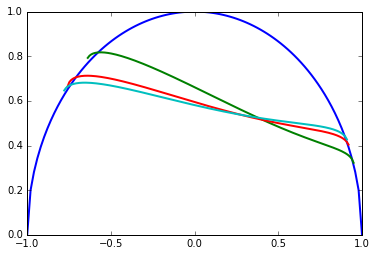

In [22]:
test2()